# SIG data exercise: stock price data

# Data: examining, cleaning, dataframes

1) Predict volatility for the next month given the samples

2) Confidence in prediction

Let's start with importing the data into a dataframe and just getting familiar with it

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import stats

#import statsmodels as sm
#import seaborn as sns

%matplotlib inline

In [2]:
df=pd.read_csv('./stockdata2.csv')
df.describe()

,day,a,b,c,d,e,f
count,98352.00000,98281.000000,98352.000000,98322.000000,98334.000000,98352.000000,96981.000000
mean,181.29732,363.767737,10.048836,69.428375,49.803747,47.727738,13.204838
std,104.61705,28.281333,3.332643,28.670322,4.539923,7.053875,2.404705
min,1.00000,0.000000,4.885000,33.807000,1.000000,38.550000,9.365000
25%,89.00000,341.785000,6.605000,45.330750,46.175000,42.040000,10.945000
50%,180.00000,357.915000,10.595000,50.960000,50.105000,45.410000,13.325000
75%,271.00000,387.890000,13.465000,101.895000,53.735000,51.350000,15.035000
max,362.00000,426.560000,15.335000,116.385000,62.137000,69.210000,18.815000


So the data appears to be grouped by day. Doing a quick glance at the data, full days seem to have 391 entries (between 9:30AM to 4:00PM) while weekends and holidays are empty. Let's do a few preliminary plots to get a feeling.

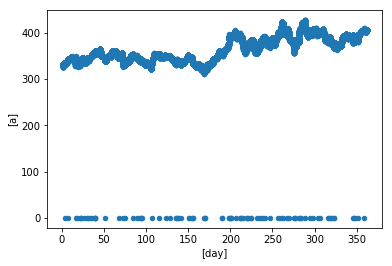

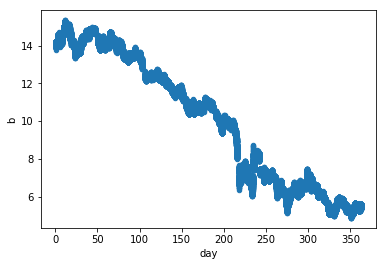

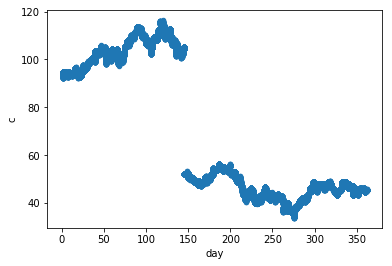

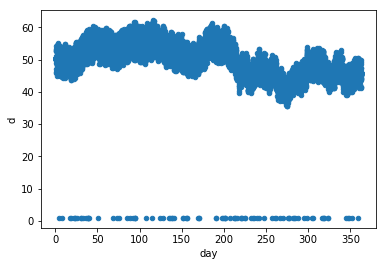

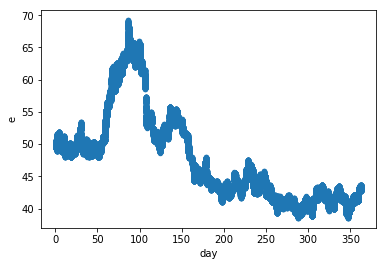

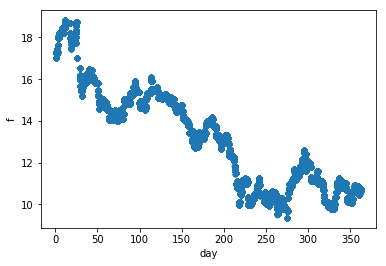

In [3]:
df.plot(x=['day'],y=['a'],kind='scatter')
df.plot(x='day',y='b',kind='scatter')
df.plot(x='day',y='c',kind='scatter')
df.plot(x='day',y='d',kind='scatter')
df.plot(x='day',y='e',kind='scatter')
df.plot(x='day',y='f',kind='scatter')

A few things to note: a major price shock in $c$ which is otherwise relatively stable, and a small, short-term bubble in the price of $e$. The day-to-day volatility of $d$ seems large compared to its longer-term volatility. Prices of $f$ are very illiquid and don't seem to move much minute to minute or even day to day. We also note that there are a few cases where stock a and stock d seem to drop precipitously, let's examine that:

In [4]:
print(len(df[df['a']==0]))
print(len(df[df['d']<10]))
df[(df['a']==0) & (df['d']<10)]
print("Mean number of days per month: "+str(len(df['day'].unique())/12))
print("Mean number of time points per day: "+str(len(df)/(12*21)))
for ii in df['day'].unique():
    if(len(df[df['day']==ii])!=391):
        print("Day "+str(ii)+" has "+str(len(df[df['day']==ii]))+" time points!")
        print(df[df['day']==ii].tail())


93
93
Mean number of days per month: 21.0
Mean number of time points per day: 390.2857142857143
Day 327 has 211 time points!
       day   timestr        a      b       c       d      e      f
88963  327  12:56:00  364.570  5.115  43.413  43.935  40.24  9.765
88964  327  12:57:00  364.700  5.115  43.405  43.875  40.24  9.765
88965  327  12:58:00  364.545  5.215  43.405  43.865  40.27  9.765
88966  327  12:59:00  364.380  5.125  43.325  43.855  40.33  9.765
88967  327  13:00:00  363.580  5.225  43.333  43.835  40.31  9.765


The times of the dips in stock $a$ are sporadic, seemingly unrelated times, on different days, and also correspond to the dips in stock $d$. Likely these dips are due to recording errors, and as a result this data is best cleaned via setting to NaN, since we plan to use the rolling window functionality of pandas. We note that stocks $b$ and $e$ have no null entries, no spurious dips, and are fully represented in the data set. In addition, we note that the data is conveniently divided up into 21 days per month, but there seem to be a day (327) that doesn't have the full number of time points where trading stops at 1pm. We handle this a bit later after we have decided on how we will compute the monthly volatility give our other analysis.

In [5]:
print(pd.isnull(df[['a','b','c','d','e','f']]).sum())

a      71
b       0
c      30
d      18
e       0
f    1371
dtype: int64


Let's now examine the nature of the null data in the other stocks on a daily basis and take a look at how many minutes out of each day does the data register as null:

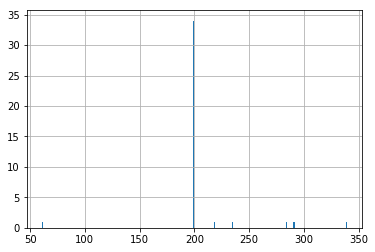

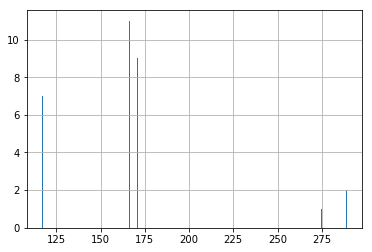

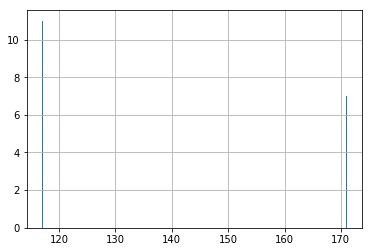

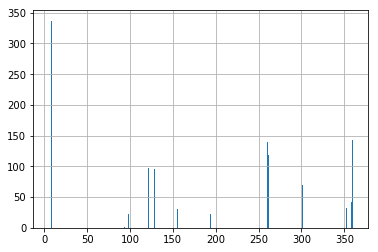

In [6]:
for ii in ['a','c','d','f']:
    df[pd.isnull(df[ii])]['day'].hist(bins=362)
    plt.show()

Most days are only missing a few minutes in a day , with the exception of stock $f$, which has several days in which at least a third of the data in a day is sometimes missing. Although it is very reasonable to perform simple interpolations for individual missing minutes, drawing a curve through large chunks of missing data will artificially and significantly affect volatility inference for that day. However, in the case of $f$ pricing, movements are so slow that in many cases replacing NaN values may be reasonable. Let's do the simple cleaning first: replacing spurious values in $a$ and $d$ as missing

In [7]:
df_clean=df.copy() #copy base data into new dataframe
#replace spurious prices -> missing
df_clean['a']=df['a'].replace(0,np.nan);
df_clean['d']=df['d'].replace(1.0,np.nan);

After cleaning the data, we want to look at log prices since we are going to explore volatility on log returns.

In [8]:
plist=list('abcdef')
logdf=np.log(df_clean[plist])
logdf['day']=df_clean['day'].copy()
logdf['timestr']=df_clean['timestr'].copy()
logdf=logdf[df_clean.columns.tolist()]

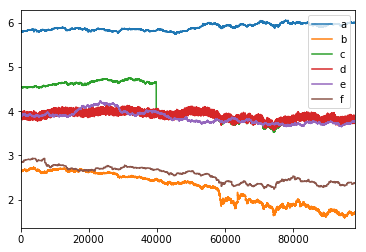

In [9]:
#plot log prices 
logdf.loc[:,'a':'f'].plot()

We see that the price of $d$ has high intra-day volatility despite having low monthly volatility. We consider a dataset that averages out the intra-day moves and see how it compares. We also note that $b$ appears to show an increase in volatility around day 215

In [10]:
dayseries=df_clean['day'].unique();
logdf_day=pd.DataFrame({'day': dayseries,'a': dayseries,'b': dayseries,'c': dayseries,'d': dayseries,'e': dayseries,'f': dayseries})
logdf_day=logdf_day[['day','a','b','c','d','e','f']]
#creates daily averaged data
for idx,ii in enumerate(logdf_day['day']):
    logdf_day.iloc[idx,1:]=np.log(df_clean[df_clean['day']==ii].mean(axis=0))

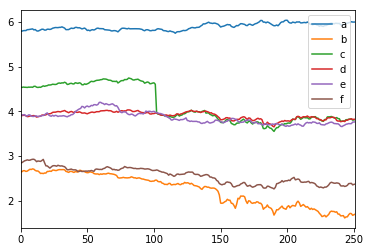

In [11]:
logdf_day.loc[:,'a':'f'].plot()

In principle, markets don't move when they are closed so we should be able to just concatenate the time-course data. But let's do a quick comparison between 1) general price moves, 2) overnight price moves, and 3) weekend price moves

In [12]:
df_diff=logdf[['day']+plist].diff(1)
normdiff=df_diff[df_diff['day']==0][plist]
daydiff=df_diff[df_diff['day']==1][plist]
enddiff=df_diff[df_diff['day']>1][plist]

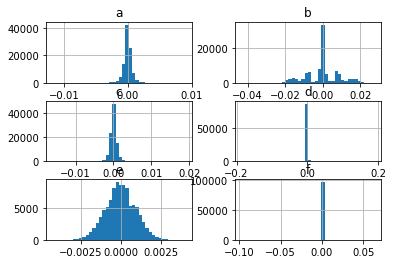

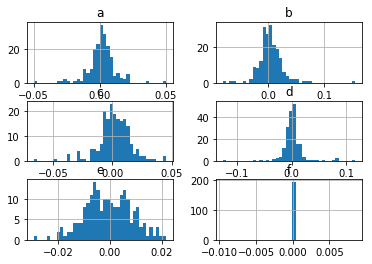

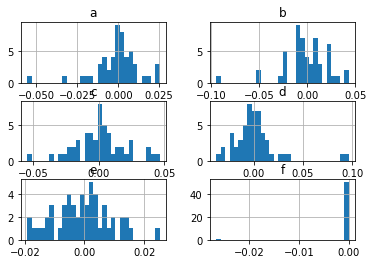

In [13]:
normdiff[normdiff['c']>-0.6].hist(bins=40);plt.show() #exclude massive mid-day drop in price of $c$
daydiff.hist(bins=40);plt.show()
enddiff.hist(bins=30);plt.show()

We see that for the most part between all the data sets, although daily price moves are quite different from overnight price moves, overnight and weekend price moves aren't all that different from each other. We can quantify this with p-values of the Kolmogorov-Smirnov 2-sample test, which is a bit more powerful than a paired t-test: it captures shape differences in the distribution and not just a single summary statistic. We observe that differences between minute moves and overnight as well as weekend moves are significant (except for $f$), while differences between overnight and weekend moves are not statistically significant. This is good: we don't have to worry about differentiating between overnight and weekend moves

In [14]:
ks_normday=pd.DataFrame(np.zeros([2,len(plist)]),columns=plist)
ks_normend=pd.DataFrame(np.zeros([2,len(plist)]),columns=plist)
ks_dayend=pd.DataFrame(np.zeros([2,len(plist)]),columns=plist)
for ii in plist:
    ks_normday[ii]=stats.ks_2samp(normdiff[ii],daydiff[ii])
    ks_normend[ii]=stats.ks_2samp(normdiff[ii],enddiff[ii])
    ks_dayend[ii]=stats.ks_2samp(daydiff[ii],enddiff[ii])
print('Likelihood that minute and overnight moves drawn from same dist:')
print(ks_normday.iloc[1,:])
print('Likelihood that minute and weekend moves drawn from same dist:')
print(ks_normend.iloc[1,:])
print('Likelihood that overnight and weekend moves drawn from same dist:')
print(ks_dayend.iloc[1,:])

Likelihood that minute and overnight moves drawn from same dist:
a    2.504041e-48
b    2.618265e-12
c    3.341174e-41
d    4.360172e-28
e    1.444428e-35
f    1.000000e+00
Name: 1, dtype: float64
Likelihood that minute and weekend moves drawn from same dist:
a    8.146079e-10
b    4.911529e-03
c    3.121738e-10
d    2.044906e-09
e    2.041272e-09
f    1.000000e+00
Name: 1, dtype: float64
Likelihood that overnight and weekend moves drawn from same dist:
a    0.206434
b    0.513888
c    0.380714
d    0.367135
e    0.764701
f    1.000000
Name: 1, dtype: float64


This particular dataset which has averaged over the daily price moves is easy to compute the monthly log returns. We take a month to be 21 business days and ignore weekends (without needing to window actual number of days) due to the analysis above. Let's define here the function we use to compute a monthly volatility over some time window. The default window (391 entries) is the number of minutes in a market day

In [15]:
#def vol_roll(dataframe,window=391):

Now, to make predictions on monthly volatility there are a few basic considerations: different time windows to compute monthly volatility (utilizing a simple brownian walk model  $\sigma_{T} = \sigma_{t} \sqrt{T / t}$ to project into longer time windows -- in principle this could be extended to a broader class of walks with memory (Levy, fractional Brownian), but that would turn this exercise into a more extensive project); and memory functions of varying time-scales when regressing on past data.

For the purposes of this exercise, if we are really interested in statistics on monthly log returns in that we are interested in the statistics on returns after holding an asset for a month, then we should be computing monthly log returns and examining the statistics. In my opinion, inferring from models should be utilized primarily to 1) validate assumptions or if 2) data are not available.

To this end, we create dataframes of monthly log returns: $R_m(t) = \log r_m(t) = \log p(t+t_m) - \log p(t)$. We then calculate the $\sigma_m(t)$ by sampling the monthly log returns of that windowed day, over the range $[t,t+t_d]$:
$$\sigma_m(t) = \sqrt{\displaystyle  \left[\frac{1}{t_d(t_d+1)}\sum_{j=0}^{t_d} \left(R_m(t+j) -
\frac{1}{t_d+1} \sum_{i=0}^{t_d} R_m(t+i)\right) \right]^2} $$

The inherent assumption here now is that volatility moves, but should take its statistics over a windowed time period over which it does not change substantially. To check this, we then plot $\sigma_m(t)$ under our window, ensuring that 1) the idea of a reasonable stable volatility within a windowed time frame is reasonable and 2) we have the statistical power to capture this idea.

Given this approach, we handle day 327 by inserting NaN into the time slots past 1pm when the markets have closed, in order to capture the fact that we simply have less data out of that time period.

In [16]:
#references to days < and > day 327
logdflt327=logdf[logdf['day']<327]
logdfgt327=logdf[logdf['day']>327]
logdf327temp=logdf[logdf['day']==327].copy() #copy a new version of day 327 data to prevent pointer issues
new_index=pd.Index(logdf[logdf['day']==330]['timestr']) #set a new index based on something with a whole day of time
logdf327=logdf327temp.set_index('timestr').reindex(new_index).reset_index() #set index, reindex to longer series, then reset
#above process sets missing columns to None, so make sure the day is referred to correctly.
logdf327['day']=327
#now concatenate the dataframe in the following fashion: 
logdf_clean=pd.concat([logdflt327,logdf327,logdfgt327],ignore_index=True) #concatenate, and reset index via ignore_index=True 
logdf_clean=logdf_clean[['day','timestr']+plist] #re-order 
#check to make sure these two numbers are the same!
#difference in data entries between "cleaned" (extended) data and original, and a normal day vs short day 327
#print(len(logdf_clean)-len(logdf))
#print(len(logdf[logdf['day']==330])-len(logdf[logdf['day']==327]))
#print(len(logdf_clean[logdf_clean['day']==327]));print(len(logdf[logdf['day']==330])) #check to make sure this is the same as other days

(0, 0.1)

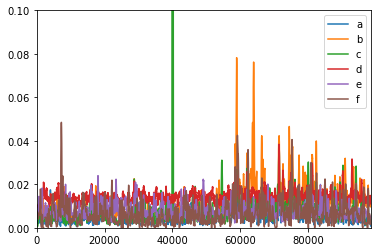

In [17]:
t_d = 391 #number of timesteps in a day, used for windowing
t_m = t_d*21 #number of timesteps in a month, used for shift in computing monthly log return
R_m = logdf_clean[plist].shift(-t_m) - logdf_clean[plist] #monthly log return
#remainder of R_m dataframe columns and column ordering
R_m[['day','timestr']]=logdf_clean[['day','timestr']].copy();R_m=R_m[['day','timestr']+plist]
#compute monthly volatility of rate of return by rolling values with window=t_d, min_periods=t_d//2 (integer div), sample stdev
sigma_m = logdf_clean.rolling(t_d,min_periods=t_d//2).std(ddof=1)
sigma_m[['day','timestr']]=R_m[['day','timestr']].copy()
sigma_m=sigma_m[['day','timestr']+plist]
sigma_m.loc[:,'a':'f'].plot()
plt.ylim([0,0.1])

After playing with this rolling dataset for awhile, it's huge and takes a long time to run on my computer with all the relevant model fits. So I will just progress utilizing statistics taken from each day, rather than a full rolling window

(0, 0.1)

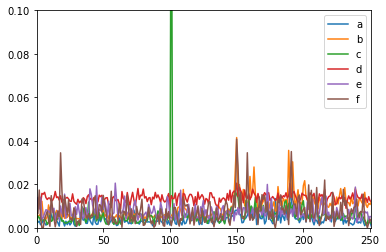

In [81]:
sigma_m_coarse=pd.DataFrame(np.random.randn(len(logdf_clean['day'].unique()),7),columns=[['day']+plist])
sigma_m_coarse['day']=logdf_clean['day'].unique().copy()
#sigma_m_coarse[sigma_m_coarse['day']==1].iloc[:,1:]
#logdf_clean[logdf_clean['day']==3].std(ddof=1).values.reshape(1,7)[:,1:]
for ii in logdf_clean['day'].unique():
    #temp=logdf_clean[logdf_clean['day']==ii].std(ddof=1).values.reshape(1,7)
    sigma_m_coarse.loc[sigma_m_coarse['day']==ii,'a']=logdf_clean[logdf_clean['day']==ii]['a'].std(ddof=1)
    sigma_m_coarse.loc[sigma_m_coarse['day']==ii,'b']=logdf_clean[logdf_clean['day']==ii]['b'].std(ddof=1)
    sigma_m_coarse.loc[sigma_m_coarse['day']==ii,'c']=logdf_clean[logdf_clean['day']==ii]['c'].std(ddof=1)
    sigma_m_coarse.loc[sigma_m_coarse['day']==ii,'d']=logdf_clean[logdf_clean['day']==ii]['d'].std(ddof=1)
    sigma_m_coarse.loc[sigma_m_coarse['day']==ii,'e']=logdf_clean[logdf_clean['day']==ii]['e'].std(ddof=1)
    sigma_m_coarse.loc[sigma_m_coarse['day']==ii,'f']=logdf_clean[logdf_clean['day']==ii]['f'].std(ddof=1)

(0, 0.1)

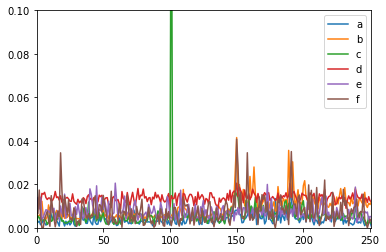

In [82]:
sigma_m_coarse.loc[:,'a':'f'].plot()
plt.ylim([0,0.1])

In [24]:
#Import a few tools useful for time series analysis

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

In [83]:
#Check for stationarity
adf_res={}
for ii in plist:
    adf_res[ii]=smt.adfuller(sigma_m_coarse[ii].dropna(),autolag='BIC') #bayesian information criterion for lag determination

In [84]:
for ii in plist:
    print(adf_res[ii])
#we probably could have discerned from the original plots, but it's good to check: $sigma_m$ appears to be stationary

(-11.600994541508648, 2.6490943669820378e-21, 0, 251, {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}, -2190.3945375366502)
(-3.7358558729649323, 0.0036361627845187734, 2, 249, {'1%': -3.4568881317725864, '5%': -2.8732185133016057, '10%': -2.5729936189738876}, -1931.2243560139921)
(-15.493698041619592, 2.4660802407462981e-28, 0, 251, {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}, -1378.5545050989124)
(-13.947654758375727, 4.7649300572724862e-26, 0, 251, {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}, -2241.9255854875619)
(-16.044850583327126, 5.8600362052596073e-29, 0, 251, {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}, -2001.9865663737708)
(-11.969910629688988, 3.920386904669901e-22, 0, 251, {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}, -1742.7264469981294)


Given the stationary nature of the data, it is reasonably safe to utilize regular autoregression and vector autoregression, which we do next. This should be unsurprising, as we have already taken log differences and taken a windowed statistic

# Forecasting: univariate and multivariate approaches

In our time series forecasting, we will test 1) univariate approaches as well as 2) multivariate approaches, in case there is cross-correlation between data sets. It seems likely, given that $a$ and $d$ in particular show spurious values at the same time points.

First, let's do univariate methods, like autoregression and autoregression moving average. We first try and ascertain what the best set of lag variables should be for each dataset, with maximum lag being a full day, utilizing the Bayes information criterion in order to incur parameter penalty.

Another possibility is cross-validation through resampling or by k-folding the empirical data, which is usually performed on data without a time component. But for time-series data I worry about how to perform it carefully in order to avoid introducing a bias due to the dynamical nature. So I avoid it for now and utilize an informational entropy penalty. I've been told that there is current research ongoing in so called "sloppy models" (James Sethna) and characterizations of model entropy via "soft directions" in parameter space (Bill Bialek) that may shed some light on the underpinnings of such information criteria.

In [85]:
max_lag=10 #maximum lag is more than a month (being 21 days) just to validate
est_order={}
for ii in plist:
    #use Bayes information criterion as model parameter penalty
    AR_model[ii]=smt.AR(sigma_m[ii]).fit(maxlag=max_lag,ic='bic')
    est_order[ii]=smt.AR(sigma_m_coarse[ii].dropna().values).select_order(maxlag=max_lag,ic='bic') 
print(est_order)

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:316: RuntimeWarning: invalid value encountered in log
  logdet + diffpVpinv / sigma2 + ssr / sigma2)
C:\Program Files\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:584: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
C:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:585: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
C:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:585: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Program Files\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:586: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
C:\Program Fi

{'a': 1, 'd': 1, 'c': 1, 'b': 3, 'f': 1, 'e': 1}


Although these are good places to start, let us examine the autocorrelations and partial autocorrelations to make our own determination

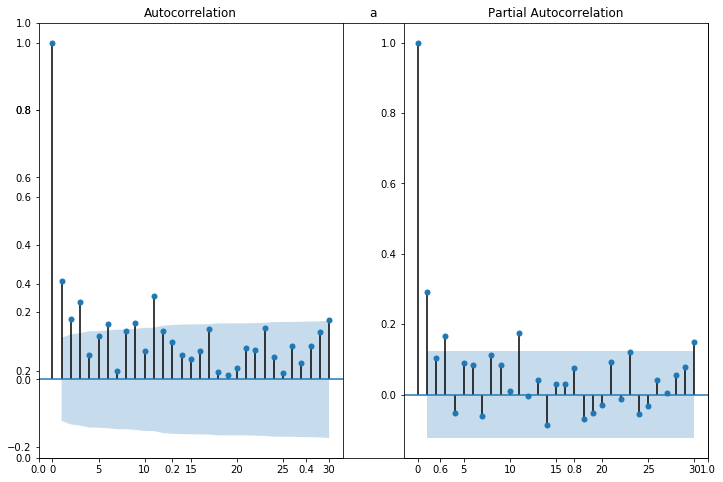

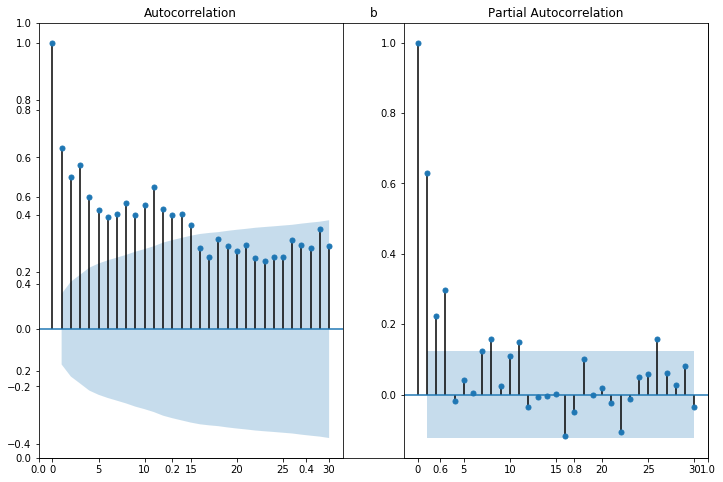

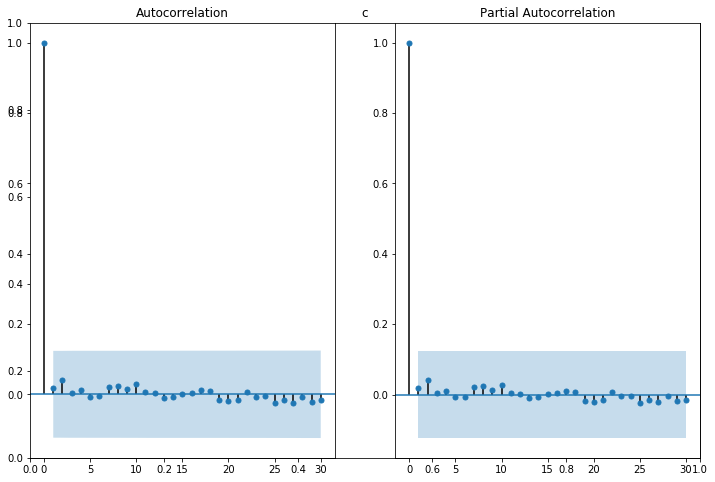

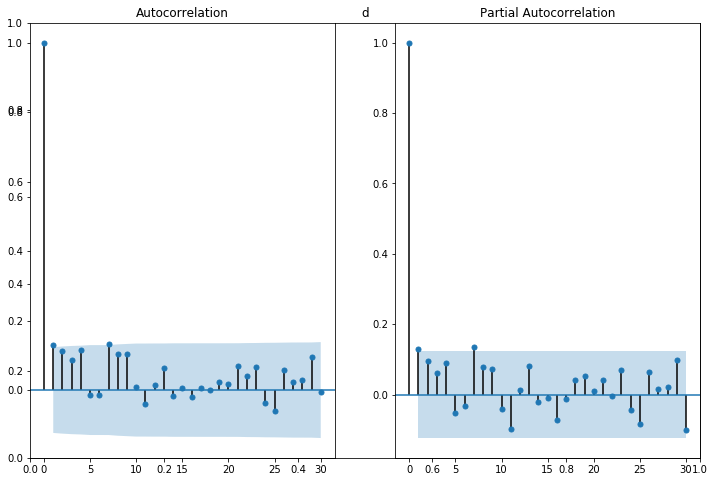

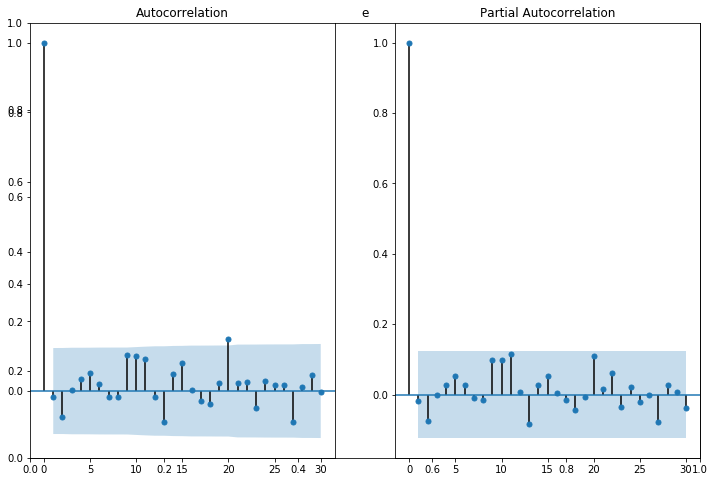

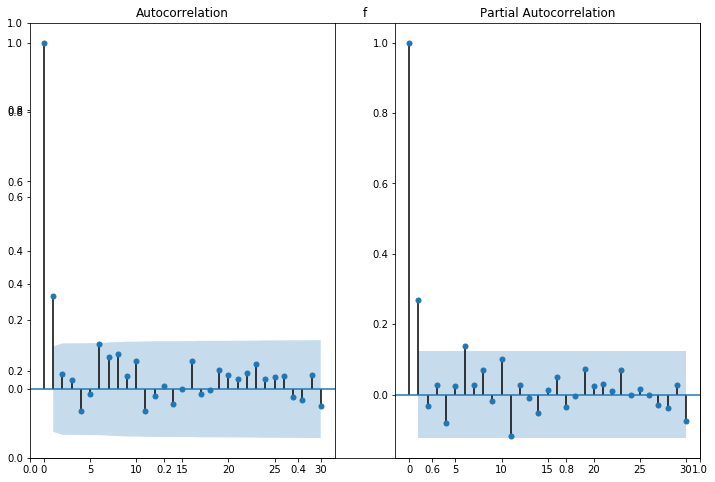

In [89]:
#Let's examine autocorrelation and partial autocorrelation
for ii in plist:
    fig=plt.figure(figsize=(12,8))
    plt.title(ii)
    ax1=fig.add_subplot(121)
    fig = sm.graphics.tsa.plot_acf(sigma_m_coarse[ii].values.squeeze(),lags=30,ax=ax1)
    ax2=fig.add_subplot(122)
    fig = sm.graphics.tsa.plot_pacf(sigma_m_coarse[ii],lags=30,ax=ax2)


We use the amplitudes from autocorrelation (AC) and partial autocorrelation (PAC) to make guesses at an ARMA(p,q) model for each price. This should be validated in the end using either cross-validation of an information criterion to prevent over-fitting. At these time-scales with this averaging scheme, $c$ appears to just be uncorrelated random noise, while $d$, and $e$ appear to be close to uncorrelated random noise as well. The PAC of $b$ appears to have some significant structure to it with a slowly decaying AC, suggesting a $(3,0)$ model. $a$ also has a slowly decaying AC, suggesting perhaps a $p=1$ model given the PAC. While $f$ demonstrates oscillating AC and PAC, perhaps suggesting a $(1,1)$ model.

In [91]:
pq = pd.DataFrame(index=['p','q'],columns=plist)
pq.set_value('p','a',1);pq.set_value('q','a',0)
pq.set_value('p','b',3);pq.set_value('q','b',0)
pq.set_value('p','c',0);pq.set_value('q','c',0)
pq.set_value('p','d',0);pq.set_value('q','d',0)
pq.set_value('p','e',0);pq.set_value('q','e',0)
pq.set_value('p','f',1);pq.set_value('q','f',1)

,a,b,c,d,e,f
p,1,3,0,0,0,1
q,0,0,0,0,0,1


Let's do some AR(1) and AR(3) model predictions on $a$ and $b$, and some ARMA(1,1) fitting on $f$:

In [99]:
a_model = sm.tsa.ARMA(sigma_m_coarse['a'].values,(1,0)).fit(disp=False)
b_model = sm.tsa.ARMA(sigma_m_coarse['b'].values,(3,0)).fit(disp=False)
f_model = sm.tsa.ARMA(sigma_m_coarse['f'].values,(1,1)).fit(disp=False)


In [100]:
print(a_model.params)
print(b_model.params)
print(f_model.params)

[ 0.00382272  0.29409227]
[ 0.00922955  0.4212474   0.0774484   0.29740473]
[ 0.00747417  0.11560885  0.16233449]


Now we give the predicted volatility for the subsequent 21 days after the data given these models, as well as model summaries which give confidence intervals around parameter values

In [102]:
#predictions
beg=len(sigma_m_coarse['a'].values)
predict_a = a_model.predict(start=beg,end=beg+21)
predict_b = b_model.predict(start=beg,end=beg+21)
predict_f = f_model.predict(start=beg,end=beg+21)
print(predict_a)
print(predict_b)
print(predict_f)

[ 0.00288717  0.00354758  0.0037418   0.00379892  0.00381572  0.00382066
  0.00382211  0.00382254  0.00382267  0.0038227   0.00382271  0.00382272
  0.00382272  0.00382272  0.00382272  0.00382272  0.00382272  0.00382272
  0.00382272  0.00382272  0.00382272  0.00382272]
[ 0.01117619  0.01070795  0.01086232  0.01061079  0.01037753  0.0103057
  0.01018257  0.01005577  0.00997145  0.0098895   0.00981073  0.00974613
  0.00968844  0.00963571  0.00958982  0.00954924  0.00951291  0.00948082
  0.00945242  0.00942717  0.00940479  0.00938495]
[ 0.00628897  0.00733715  0.00745832  0.00747233  0.00747395  0.00747414
  0.00747416  0.00747416  0.00747417  0.00747417  0.00747417  0.00747417
  0.00747417  0.00747417  0.00747417  0.00747417  0.00747417  0.00747417
  0.00747417  0.00747417  0.00747417  0.00747417]


In [104]:
a_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  252
Model:                     ARMA(1, 0)   Log Likelihood                1182.221
Method:                       css-mle   S.D. of innovations              0.002
Date:                Mon, 04 Sep 2017   AIC                          -2358.442
Time:                        23:17:46   BIC                          -2347.854
Sample:                             0   HQIC                         -2354.181
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.000     19.331      0.000       0.003       0.004
ar.L1.y        0.2941      0.060      4.875      0.000       0.176       0.412
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.4003           +0.0000j            3.4003            0.0000
-----------------------------------------------------------------------------
"""

In [105]:
b_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  252
Model:                     ARMA(3, 0)   Log Likelihood                1050.683
Method:                       css-mle   S.D. of innovations              0.004
Date:                Mon, 04 Sep 2017   AIC                          -2091.365
Time:                        23:21:25   BIC                          -2073.718
Sample:                             0   HQIC                         -2084.265
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0092      0.001      8.224      0.000       0.007       0.011
ar.L1.y        0.4212      0.060      7.029      0.000       0.304       0.539
ar.L2.y        0.0774      0.065      1.185      0.237      -0.051       0.206
ar.L3.y        0.2974      0.060      4.973      0.000       0.180       0.415
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1277           -0.0000j            1.1277           -0.0000
AR.2           -0.6940           -1.5811j            1.7268           -0.3158
AR.3           -0.6940           +1.5811j            1.7268            0.3158
-----------------------------------------------------------------------------
"""

In [106]:
f_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  252
Model:                     ARMA(1, 1)   Log Likelihood                 943.005
Method:                       css-mle   S.D. of innovations              0.006
Date:                Mon, 04 Sep 2017   AIC                          -1878.010
Time:                        23:21:42   BIC                          -1863.892
Sample:                             0   HQIC                         -1872.329
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0075      0.000     15.758      0.000       0.007       0.008
ar.L1.y        0.1156      0.288      0.401      0.689      -0.449       0.681
ma.L1.y        0.1623      0.291      0.559      0.577      -0.407       0.732
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            8.6499           +0.0000j            8.6499            0.0000
MA.1           -6.1601           +0.0000j            6.1601            0.5000
-----------------------------------------------------------------------------
"""

Given that $c$, $d$, and $e$ appear to be effectively white noise models, it is sufficient to calculate their statistics. We show the box plots here on values of their volatility for all future time 

In [109]:
import seaborn as sns

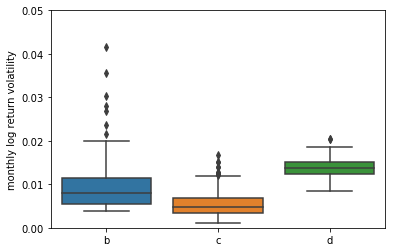

In [113]:
plt.figure()
sns.boxplot(data=sigma_m_coarse[['b','c','d']])
plt.ylim([0,0.05])
plt.ylabel('monthly log return volatility')

# Finally:

In truth, I should test these results: comparing model predictions to internal values, and/or optimizing based upon information criterion. I also neglected to perform vector AR models. However, there are almost always an infinite number of ways to parse, clean, and model data which rarely ever ends. The most reliable way to validate an approach is to continually cross-validate and re-examine endlessly as new models are utilized and new data comes in. I hope I've been able to demonstrate some of my process and knowledge! 